In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from tqdm import tqdm
import pandas as pd


### slow memory intensive

In [4]:
# Example usage: Generate a file_list and load the spectra
def generate_file_list():
    # Define the directories containing your spectra
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    # Iterate over the directories and assign labels based on the directory name
    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                #if file.endswith(".fits"):
                file_path = os.path.join(root, file)
                file_list.append(file_path)
                labels.append(label)

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

def load_spectra(file_list, known_rows=None):
    spectra_data = []

    # First pass: determine the minimum number of rows across all spectra
    print("Determining minimum number of rows across spectra...")
    if known_rows is None:
        known_rows = np.inf
        for file_path in tqdm(file_list, desc="Finding min rows", unit="file"):
            try:
                with fits.open(file_path) as hdul:
                    # Access the primary HDU (index 0) and the first row of data
                    spectra = hdul[0].data[0]
                    known_rows = min(known_rows, len(spectra))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    # Second pass: load and truncate spectra to the minimum number of rows
    print(f"\nLoading spectra (truncated to {known_rows} rows)...")
    for file_path in tqdm(file_list, desc="Loading spectra", unit="file"):
        try:
            with fits.open(file_path) as hdul:
                # Access the first row of the primary HDU and truncate
                spectra = hdul[0].data[0][:known_rows]
                spectra_data.append(spectra)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Convert the list of spectra to a NumPy array for easier processing
    spectra_data = np.array(spectra_data)
    return spectra_datac

In [5]:
# Load the spectra and monitor progress
file_list, labels = generate_file_list()
spectra_data = load_spectra(file_list, known_rows=3748)

Gathering FITS files...
Total spectra files collected: 165948
Determining minimum number of rows across spectra...

Loading spectra (truncated to 3748 rows)...


Loading spectra:  67%|██████▋   | 111267/165948 [15:43<07:43, 117.93file/s]


KeyboardInterrupt: 

In [8]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from astropy.io import fits

def generate_file_list():
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                file_list.append(file_path)
                labels.append(label)

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

def load_spectra(file_list, known_rows=None):
    spectra_data = []
    if known_rows is None:
        known_rows = np.inf
        for file_path in tqdm(file_list, desc="Finding min rows", unit="file"):
            try:
                with fits.open(file_path) as hdul:
                    spectra = hdul[0].data[0]
                    known_rows = min(known_rows, len(spectra))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    print(f"\nLoading spectra (truncated to {known_rows} rows)...")
    for file_path in tqdm(file_list, desc="Loading spectra", unit="file"):
        try:
            with fits.open(file_path) as hdul:
                spectra = hdul[0].data[0][:known_rows]
                spectra_data.append(spectra)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    spectra_data = np.array(spectra_data)
    return spectra_data

def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    # Load and parse the FITS files
    def load_and_parse(file_path, label):
        # Load spectra from FITS file
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    # Apply the loading function to the dataset
    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch the data
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

def split_dataset(file_list, labels, val_split=0.2):
    total_size = len(file_list)
    val_size = int(val_split * total_size)
    
    # Shuffle the data before splitting
    indices = np.random.permutation(total_size)
    train_indices, val_indices = indices[val_size:], indices[:val_size]
    
    train_files = [file_list[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    val_files = [file_list[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    
    return train_files, train_labels, val_files, val_labels

# Example usage
file_list, labels = generate_file_list()

# Split the dataset
train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)

# Create TensorFlow datasets
train_dataset = create_dataset(train_files, train_labels)
val_dataset = create_dataset(val_files, val_labels)


Gathering FITS files...
Total spectra files collected: 165948


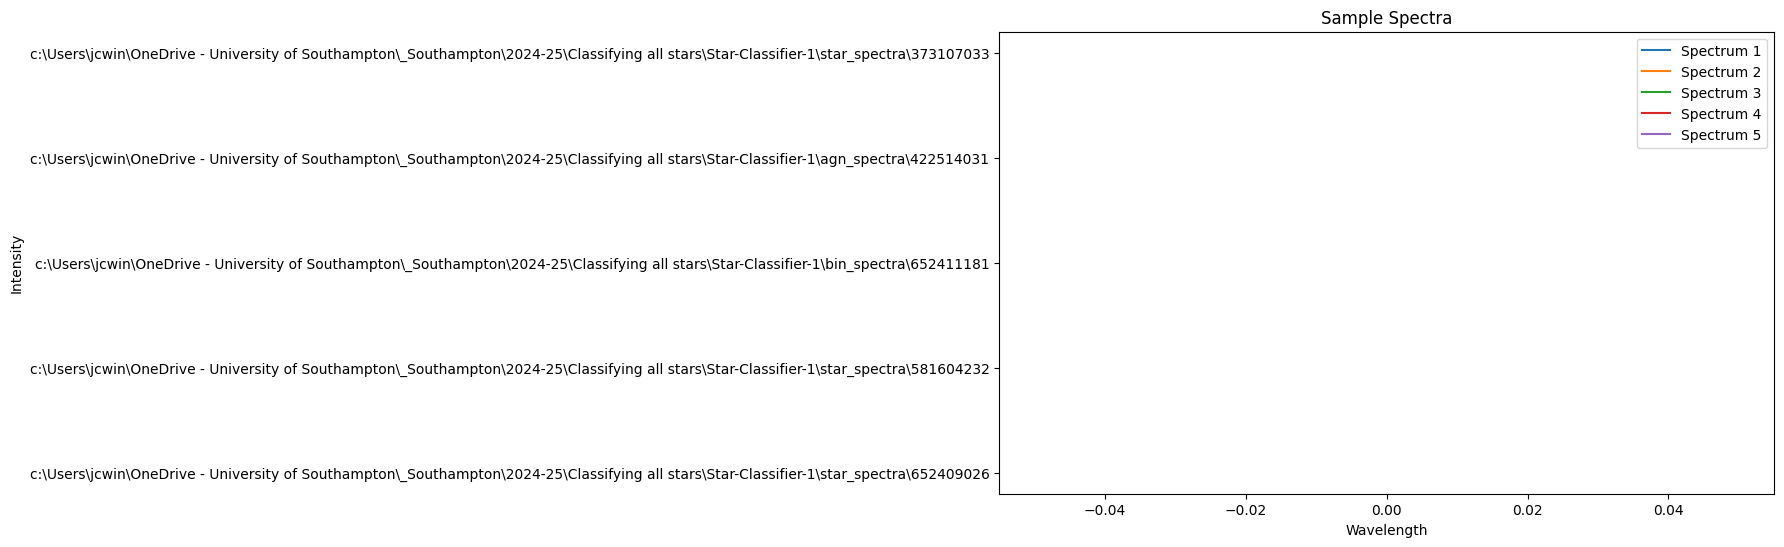

In [10]:
# New function to plot the spectra
def plot_sample_spectra(file_list, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(min(num_samples, len(file_list))):
        try:
            with fits.open(file_list[i]) as hdul:
                spectra = hdul[0].data[0]
                plt.plot(spectra, label=f'Spectrum {i+1}')
        except Exception as e:
            print(f"Error reading {file_list[i]}: {e}")
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.title('Sample Spectra')
    plt.legend()
    plt.show()
plot_spectra(train_files)


In [19]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt

def generate_file_list():
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                file_list.append(file_path)
                labels.append(label)

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

def load_spectra(file_list, known_rows=None):
    spectra_data = []
    if known_rows is None:
        known_rows = np.inf
        for file_path in tqdm(file_list, desc="Finding min rows", unit="file"):
            try:
                with fits.open(file_path) as hdul:
                    spectra = hdul[0].data[0]
                    known_rows = min(known_rows, len(spectra))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    print(f"\nLoading spectra (truncated to {known_rows} rows)...")
    for file_path in tqdm(file_list, desc="Loading spectra", unit="file"):
        try:
            with fits.open(file_path) as hdul:
                spectra = hdul[0].data[0][:known_rows]
                spectra_data.append(spectra)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    spectra_data = np.array(spectra_data)
    return spectra_data

def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    # Load and parse the FITS files
    def load_and_parse(file_path, label):
        # Load spectra from FITS file
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    # Apply the loading function to the dataset
    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch the data
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

def split_dataset(file_list, labels, val_split=0.2):
    total_size = len(file_list)
    val_size = int(val_split * total_size)
    
    # Shuffle the data before splitting
    indices = np.random.permutation(total_size)
    train_indices, val_indices = indices[val_size:], indices[:val_size]
    
    train_files = [file_list[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    val_files = [file_list[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    
    return train_files, train_labels, val_files, val_labels

# New function to plot sample spectra
def plot_sample_spectra(file_list, num_samples=2):
    for i in range(min(num_samples, len(file_list))):
        try:
            with fits.open(file_list[i]) as hdul:
                spectra = hdul[0].data[0]
                plt.figure(figsize=(10, 6))
                plt.plot(spectra, label=f'Spectrum {i+1}')
                plt.xlabel('Wavelength')
                plt.ylabel('Intensity')
                plt.title('Sample Spectra')
                plt.legend()
                plt.show()
        except Exception as e:
            print(f"Error reading {file_list[i]}: {e}")
    

# Example usage
file_list, labels = generate_file_list()

# Split the dataset
train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)

# Create TensorFlow datasets
train_dataset = create_dataset(train_files, train_labels)
val_dataset = create_dataset(val_files, val_labels)


Gathering FITS files...
Total spectra files collected: 165948


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt

In [ ]:
def generate_file_list():
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                file_list.append(file_path)
                labels.append(label)

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels

    def load_spectra(file_list, known_rows=None):
    spectra_data = []
    if known_rows is None:
        known_rows = np.inf
        for file_path in tqdm(file_list, desc="Finding min rows", unit="file"):
            try:
                with fits.open(file_path) as hdul:
                    spectra = hdul[0].data[0]
                    known_rows = min(known_rows, len(spectra))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    print(f"\nLoading spectra (truncated to {known_rows} rows)...")
    for file_path in tqdm(file_list, desc="Loading spectra", unit="file"):
        try:
            with fits.open(file_path) as hdul:
                spectra = hdul[0].data[0][:known_rows]
                normalized_spectra = normalize_spectra(spectra)
                spectra_data.append(normalized_spectra)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    spectra_data = np.array(spectra_data)
    return spectra_data

def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_parse(file_path, label):
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

def split_dataset(file_list, labels, val_split=0.2):
    total_size = len(file_list)
    val_size = int(val_split * total_size)
    
    indices = np.random.permutation(total_size)
    train_indices, val_indices = indices[val_size:], indices[:val_size]
    
    train_files = [file_list[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    val_files = [file_list[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    
    return train_files, train_labels, val_files, val_labels

In [ ]:
def normalize_spectra(spectra):
    """Normalize spectra by dividing by the mean and applying the natural logarithm."""
    mean_value = np.mean(spectra)
    if mean_value == 0:
        return spectra  # Avoid division by zero
    normalized_spectra = np.log1p(spectra / mean_value)  # Use log1p for numerical stability (log(1 + x))
    return normalized_spectra

In [22]:

# New function to plot sample spectra
def plot_sample_spectra(file_list, num_samples=2):
    for i in range(min(num_samples, len(file_list))):
        try:
            with fits.open(file_list[i]) as hdul:
                spectra = hdul[0].data[0]
                plt.figure(figsize=(10, 6))
                plt.plot(spectra, label=f'Spectrum {i+1}')
                plt.xlabel('Wavelength')
                plt.ylabel('Intensity')
                plt.title('Sample Spectra')
                plt.legend()
                plt.show()
        except Exception as e:
            print(f"Error reading {file_list[i]}: {e}")


Gathering FITS files...
Total spectra files collected: 165948


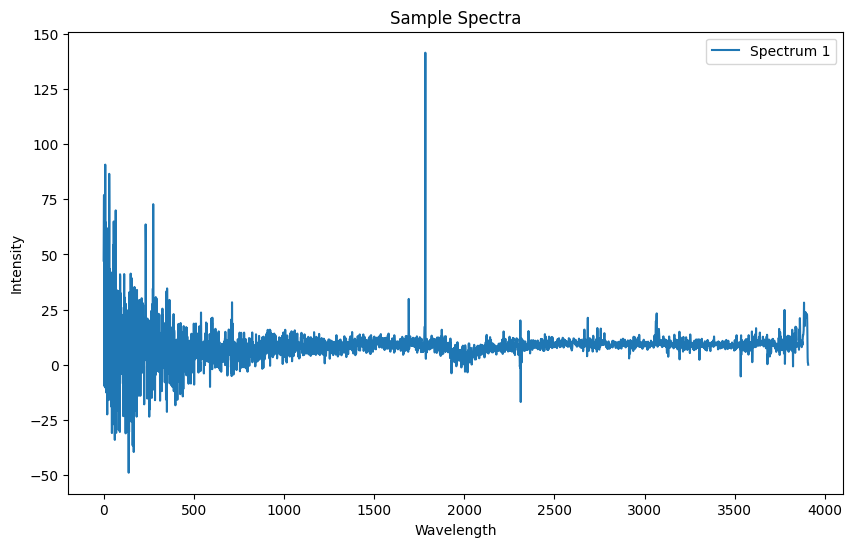

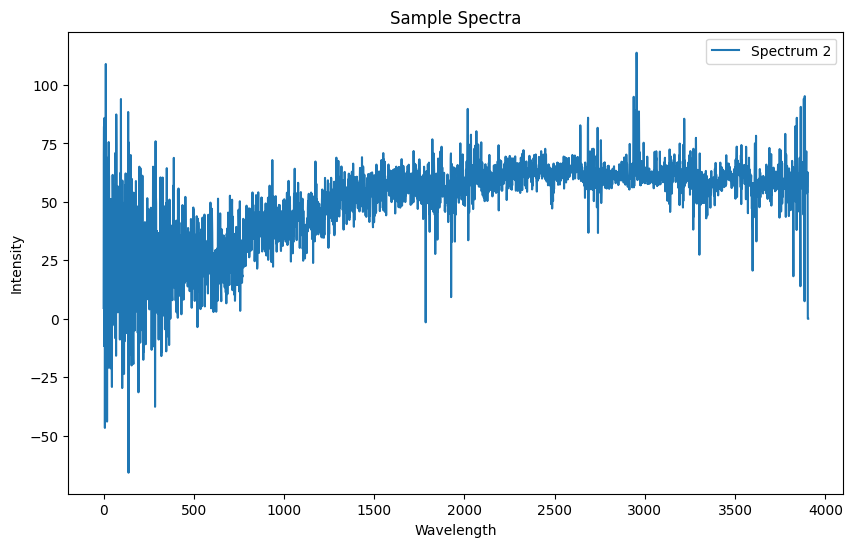

In [23]:
# Plot sample spectra to check if everything is good
plot_sample_spectra(file_list)

In [24]:
# Example usage
file_list, labels = generate_file_list()

# Split the dataset
train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)

# Create TensorFlow datasets
train_dataset = create_dataset(train_files, train_labels)
val_dataset = create_dataset(val_files, val_labels)

Gathering FITS files...
Total spectra files collected: 165948


## Defining model

In [63]:
# Function to define a CNN model with adjustable parameters
def create_convnet(input_shape, num_classes, 
                   num_filters=[32, 64], 
                   kernel_size=(7,),
                   dense_units=128, 
                   dropout_rate=0.5):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Second convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[1], kernel_size=kernel_size, 
                                     activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

## Create datasets

In [31]:
len_ = 3748

def load_single_spectrum(file_path, target_length=len_):
    """Load and normalize a single spectrum from a FITS file, truncating or padding to target_length."""
    try:
        with fits.open(file_path) as hdul:
            spectra = hdul[0].data[0]
            spectra = normalize_spectra(spectra)
            
            # Truncate or pad spectra to ensure uniform length
            if len(spectra) > target_length:
                spectra = spectra[:target_length]  # Truncate
            else:
                spectra = np.pad(spectra, (0, max(0, target_length - len(spectra))), mode='constant')  # Pad with zeros
            
            return spectra
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if there's an error

def load_all_spectra_parallel(file_list, target_length=len_, max_workers=8):
    """Load and normalize spectra in parallel using ThreadPoolExecutor."""
    spectra_data = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Use ThreadPoolExecutor to parallelize the loading of FITS files
        results = list(tqdm(executor.map(lambda f: load_single_spectrum(f, target_length), file_list), 
                            total=len(file_list), desc="Loading spectra"))

    # Filter out None results (in case any files failed to load)
    spectra_data = [spectrum for spectrum in results if spectrum is not None]

    return np.array(spectra_data)

# Example usage:
file_list, labels = generate_file_list()

# Load spectra data in parallel using multiple threads
# Set target length for uniform spectra length (adjust the target_length as needed)
spectra_data = load_all_spectra_parallel(file_list, target_length=len_, max_workers=8)

# Convert labels to numpy array
labels = np.array(labels)

# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Continue with creating train/validation datasets
train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)

# Load training and validation spectra in parallel
train_spectra = load_all_spectra_parallel(train_files, target_length=len_, max_workers=8)
val_spectra = load_all_spectra_parallel(val_files, target_length=len_, max_workers=8)

# Create TensorFlow datasets
train_dataset = create_tf_dataset(train_spectra, np.array(train_labels))
val_dataset = create_tf_dataset(val_spectra, np.array(val_labels))


Gathering FITS files...
Total spectra files collected: 165948


C:\Users\jcwin\AppData\Local\Temp\ipykernel_26688\2235372894.py:37: RuntimeWarning: invalid value encountered in log1p
  normalized_spectra = np.log1p(spectra / mean_value)  # Use log1p for numerical stability (log(1 + x))
Loading spectra: 100%|██████████| 33189/33189 [01:19<00:00, 416.64it/s]


ValueError: The `kernel_size` argument must be a tuple of 1 integers. Received: (3, 3)

## Making model

In [64]:
# Now use these datasets to train the model
convnet_model = create_convnet(input_shape=(len_, 1), num_classes=len(set(labels)))

## Train (NAN removed after)

In [52]:
import numpy as np

# Convert lists to NumPy arrays
train_spectra = np.array(train_spectra)
train_labels = np.array(train_labels)
val_spectra = np.array(val_spectra)
val_labels = np.array(val_labels)

# Remove nan values from the spectra
mask_train = ~np.isnan(train_spectra).any(axis=1)
train_spectranan = train_spectra[mask_train]
train_labelsnan = train_labels[mask_train]

mask_val = ~np.isnan(val_spectra).any(axis=1)
val_spectranan = val_spectra[mask_val]
val_labelsnan = val_labels[mask_val]

# Create TensorFlow datasets
train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)


In [53]:
convnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 3742, 32)          256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 1871, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 1865, 64)          14400     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 932, 64)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 59648)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

# Training, note it is incremental and does not restart

In [79]:
history = train_convnet(convnet_model, train_dataset, val_dataset, epochs=8, batch_size=32)

Epoch 1/8
2886/2886 [==============================] - 430s 149ms/step - loss: 0.4137 - accuracy: 0.8113 - val_loss: 0.4266 - val_accuracy: 0.8097
Epoch 2/8
2886/2886 [==============================] - 430s 149ms/step - loss: 0.4077 - accuracy: 0.8147 - val_loss: 0.4281 - val_accuracy: 0.8044
Epoch 3/8
2886/2886 [==============================] - 429s 148ms/step - loss: 0.4029 - accuracy: 0.8154 - val_loss: 0.4365 - val_accuracy: 0.8060
Epoch 4/8
2886/2886 [==============================] - 423s 146ms/step - loss: 0.3970 - accuracy: 0.8200 - val_loss: 0.4292 - val_accuracy: 0.8147
Epoch 5/8
2886/2886 [==============================] - 419s 145ms/step - loss: 0.3929 - accuracy: 0.8221 - val_loss: 0.4230 - val_accuracy: 0.8143
Epoch 6/8
2886/2886 [==============================] - 422s 146ms/step - loss: 0.3885 - accuracy: 0.8242 - val_loss: 0.4300 - val_accuracy: 0.8155
Epoch 7/8
2886/2886 [==============================] - 419s 145ms/step - loss: 0.3833 - accuracy: 0.8265 - val_loss: 0

In [82]:
# Save the model
convnet_model.save('convnet_model_v1')

INFO:tensorflow:Assets written to: convnet_model_v1\assets


INFO:tensorflow:Assets written to: convnet_model_v1\assets


## metrics

In [72]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [69]:
print(tf.config.list_physical_devices('GPU'))

[]


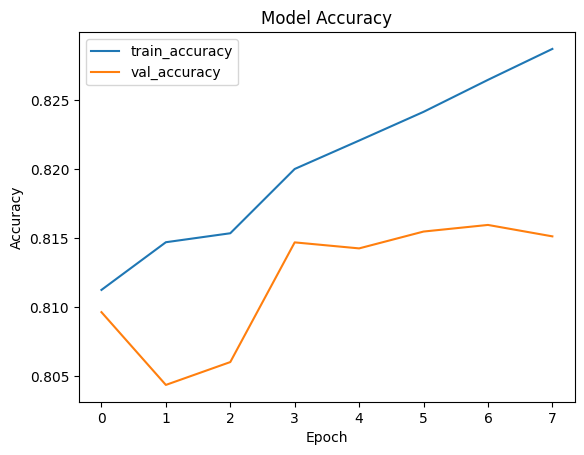

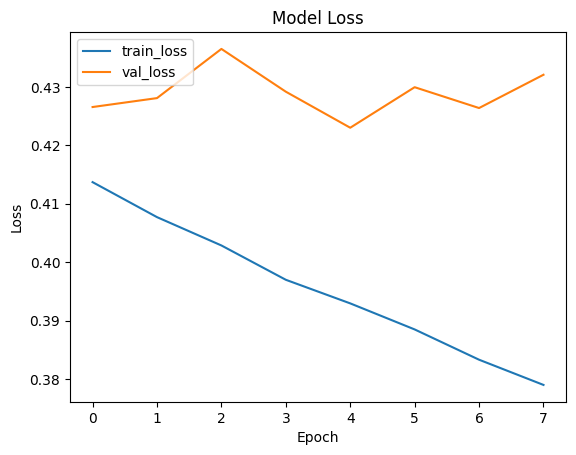

In [80]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


718/718 [==============================] - 17s 24ms/step
Confusion Matrix:
[[    0   122    13    33]
 [   25 10571  1050  2815]
 [    2  1110   101   304]
 [   11  4994   473  1324]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       168
           1       0.63      0.73      0.68     14461
           2       0.06      0.07      0.06      1517
           3       0.30      0.19      0.23      6802

    accuracy                           0.52     22948
   macro avg       0.25      0.25      0.24     22948
weighted avg       0.49      0.52      0.50     22948



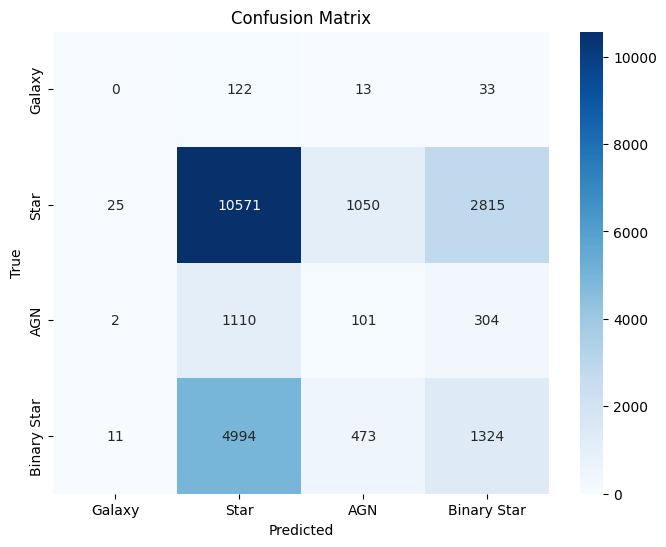

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the validation/test dataset
val_predictions = convnet_model.predict(val_dataset)

# Convert the predictions to class labels (assuming one-hot encoding)
predicted_labels = np.argmax(val_predictions, axis=1)

# Convert true labels if they are in one-hot encoded format
true_labels = np.array(val_labelsnan)  # Assuming val_labels is already numeric

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report for more metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'], yticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
